<h1 style="color: green;">Explaining the regressor model with SHAP values</h1>
<p>
Traditional methods of assessing the performance of a regressor model such as accuracy, sensitivity/recall, precision, F1 score etc<br>
don't detail the construction of the prediction. This makes it difficult to trust model output if it cannot be understood.<br>A trust worthy model has local and global fidelity:
<ul>
<li><b>Global fidelity:</b> An explaination of the positive and negative relationship between the features and the target from a wholistic model point of view</li>

<li><b>Local fidelity:</b> An explaination of how the model behaves for a single prediction i.e. the feature by feature contribution to the prediction</li>
</ul>
<b>Note, the data used is standardized data that was first encoded with weight of evidence(WOE) encoder</b>.<br>
Thus, the absolute values are not in meaningful units but they show the relationships with the prediction.
</p>

<h1 style="color: green;">Import libraries</h1>

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import joblib

# from tqdm.notebook import tqdm
import shap

import warnings
warnings.filterwarnings('ignore')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


<h1 style="color: green;">Load the data from the final classifier model</h1>

In [3]:
X_train = pd.read_csv("../2. Data/Classif_X_train_Shap.csv")
X_test  = pd.read_csv("../2. Data/Classif_X_test_Shap.csv")

In [4]:
X_train.head()

,Date_diff,Nbr_items_per_wk,Expenditure_per_wk,Total_Exp_wk_perc,AVG_exp_item_per_wk,Bread_wk,Cooked_meats_wk,Raw_meats_wk,Eating_out_wk,Snacks_wk,Drinks_wk,Vegetables_wk,Cooking_base_wk,Dairy_produce_wk,Seasoning_wk,Breakfast_wk,Transport_wk,Cosmetics_and_selfcare_wk,House_and_kitchen_wk
0,-0.516401,-2.325070,-0.360978,0.958724,0.176983,-1.338859,-0.993772,-1.846952,-0.402056,-1.178765,-1.069530,-1.423474,-0.510428,-1.155479,-0.408777,-0.53827,-0.220112,-0.841394,-0.402112
1,0.463288,-0.999776,-0.316871,1.714483,-0.179935,-0.415046,0.228272,-0.510951,-0.402056,0.406823,-0.724860,-1.423474,-0.510428,0.374484,-0.408777,-0.53827,-0.220112,-0.841394,-0.402112
2,-0.516401,-1.467527,-0.392313,1.564838,-0.217456,-0.415046,-0.382750,-0.510951,-0.402056,-1.178765,-1.069530,0.334325,0.137784,-0.390498,-0.408777,-0.53827,-0.220112,-0.841394,-0.402112
3,0.789851,-0.999776,-0.396774,1.297044,-0.247721,-0.415046,0.228272,-1.178951,-0.402056,0.935352,0.309148,-1.228163,-0.510428,0.374484,-0.408777,-0.53827,-0.220112,-0.841394,-0.402112
4,-0.516401,0.247559,-0.278559,0.049752,-0.217792,0.508766,-0.382750,0.825051,-0.402056,-1.178765,0.998487,1.115568,0.137784,0.374484,-0.408777,-0.53827,-0.220112,1.372613,-0.402112


In [5]:
X_test.head()

,Date_diff,Nbr_items_per_wk,Expenditure_per_wk,Total_Exp_wk_perc,AVG_exp_item_per_wk,Bread_wk,Cooked_meats_wk,Raw_meats_wk,Eating_out_wk,Snacks_wk,Drinks_wk,Vegetables_wk,Cooking_base_wk,Dairy_produce_wk,Seasoning_wk,Breakfast_wk,Transport_wk,Cosmetics_and_selfcare_wk,House_and_kitchen_wk
0,-0.516401,-0.142233,-0.205633,-0.650731,-0.162762,0.508766,0.839295,-1.178951,0.725153,1.199617,-0.724860,-0.251608,-0.510428,0.374484,-0.408777,-0.53827,-0.220112,-0.287892,0.447247
1,-0.516401,3.054063,-0.079719,-0.540533,-0.214806,0.508766,0.228272,0.825051,2.415968,-0.650236,0.309148,3.849921,4.027057,1.139465,-0.408777,-0.53827,0.153357,0.265610,8.091486
2,-0.516401,0.637351,-0.304977,-0.145825,-0.239991,0.508766,0.228272,0.825051,-0.402056,-1.178765,0.653817,0.724946,4.027057,0.374484,-0.408777,-0.53827,-0.220112,-0.287892,0.447247
3,0.136725,0.949185,-0.317100,-0.137612,-0.250786,0.508766,0.228272,1.493052,-0.402056,0.406823,2.032495,0.529635,-0.510428,1.139465,-0.408777,-0.53827,-0.220112,-0.287892,-0.402112
4,0.136725,-0.843859,-0.043999,-0.148023,0.020107,-1.338859,-0.993772,-1.178951,-0.402056,-0.385971,-0.380191,0.139014,0.137784,-1.155479,-0.408777,-0.53827,0.526825,-0.841394,-0.402112


<h1 style="color: green;">Load the classifier model</h1>

In [6]:
catb_final = joblib.load('../8. Models/Classifier_models/catboost_classifier14082023')

<h3 style="color: green;">Building the explainer</h3>

In [8]:
explainer =  shap.TreeExplainer(catb_final)

<h1 style="color: green;">Global fidelity</h1>
<p>
Below the focus is on the model as a whole: to generate insight with respect to<br>
the positive and negative relationship between the predictors and the target.
</p>

In [9]:
# Generating shap values
X_train_shap_values = explainer.shap_values(X_train)

In [10]:
# Preparing the colours
colors = ["#000000", "#AEEA00", "#DD2C00"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

<h3 style="color: green;">X_test global fidelity</h3>

In [11]:
# This predicts the test Expenditure_per_week and returns corresponding shap values
X_test_shap_values = explainer.shap_values(X_test)

In [12]:
X_test_shap_values.shape

(267, 19)

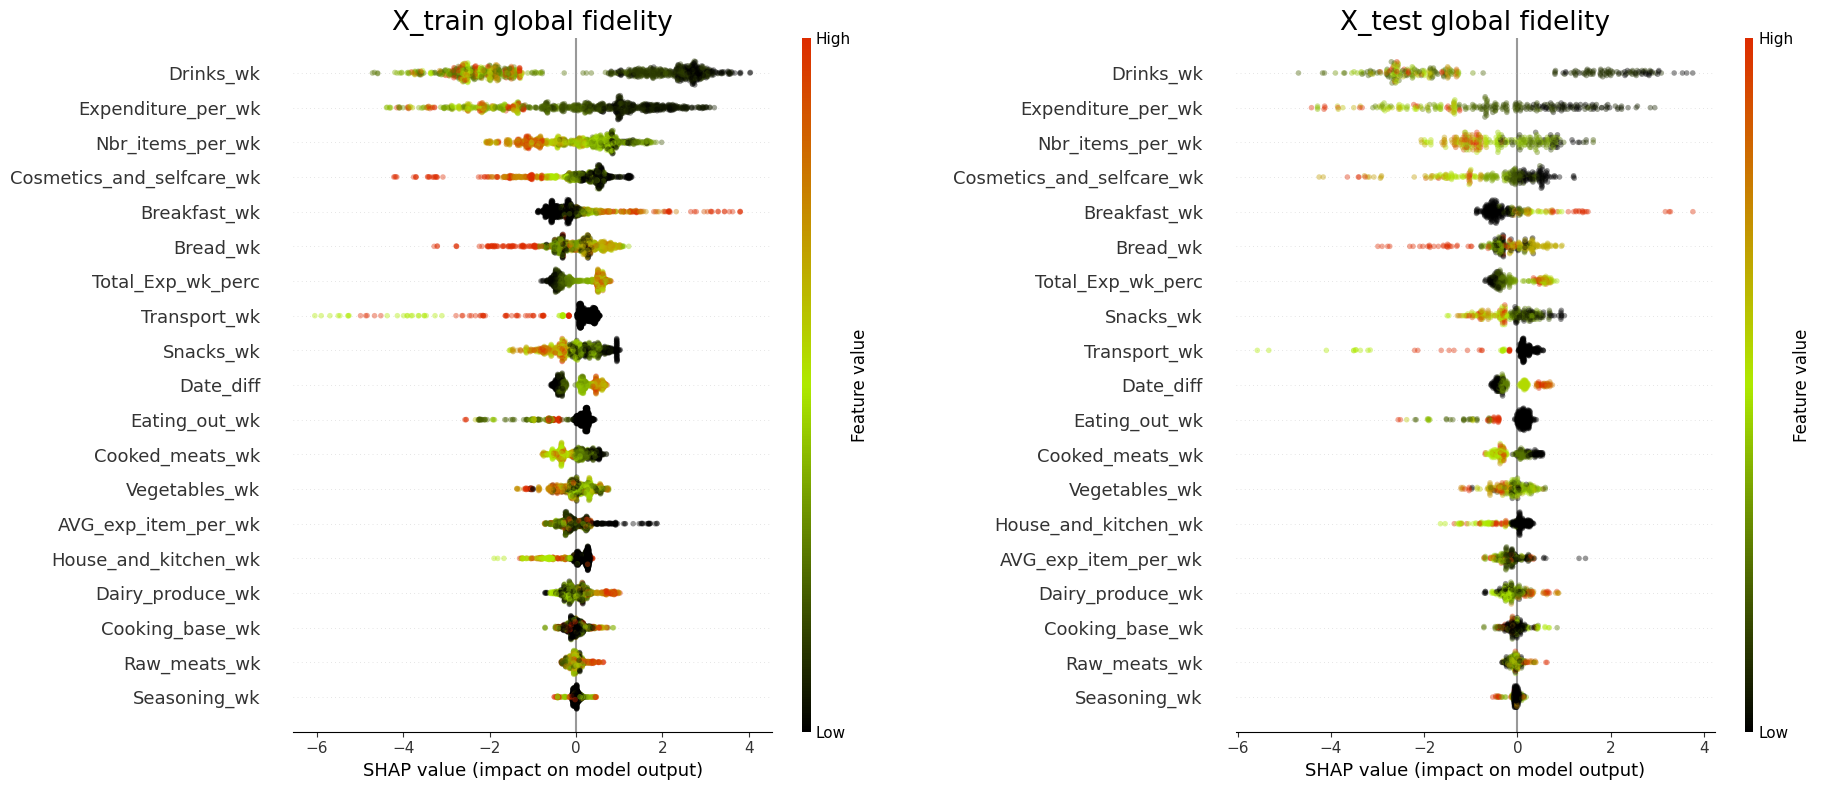

In [13]:
fig = plt.figure()
ax0 = fig.add_subplot(121)
shap.summary_plot(X_train_shap_values, X_train, cmap=cmap, alpha=0.4, show=False)
plt.title("X_train global fidelity", fontsize=19)
ax1 = fig.add_subplot(122)
shap.summary_plot(X_test_shap_values, X_test, cmap=cmap, alpha=0.4, show=False)
plt.title("X_test global fidelity", fontsize=19)

plt.gcf().set_size_inches(19,8)
plt.tight_layout()
plt.show()

<p>
The plots above show features ranked in descending order of feature importance.<br><br>
<b style="color: green;">How to read the plots</b>
<ul>
<li>Each dot represents a respective value for that feature</li>
<li>The colour of the dot represents the magnitude of the value. This is mapped to the colour bar on the right of each plot.</li>
<li><b>Effect:</b> The horizontal location, x-axis, shows whether the effect of that value is associated with a higher or lower shap value, prediction</li>
<li><b>Correlations:</b> for a given feature red dots to the right of 0 and black dots to the left of 0 indicates a positive correlation with the target while the reverse indicates a negative correlation.</li>
</ul>
<b style="color: green;">Interpreting the plots</b><br>
There is a lot of insight coming out these plots:
<ul>
<li>Mostly the ranking is preserved between X_train and X_test  with the exception of the following features swapping positions: transport_wk with snacks_wk; House_and_kitchen_wk with AVG_exp_item_per_wk.<br><br></li>
    
<li>The dispersion of the feature values along the x-axis reflects how sensitive the shap values are to changes in feature values.<br><br></li>

<li>The more important, the higher the rank, the greater the dispersion along the x-axis meaning the predictions are highly responsive to the levels of the most powerful features.<br><br></li>

<li>The distribution pattern of the dots across both train and test plots are very similar; this illustrates that there is very little data drift, if any, the underlying data distributions are the same.<br>
    
Since the plot illustrates the relationship with the prediction, there is also no concept drift from training to testing. The underlying relationship is maintained between train and test datasets e.g. Drinks_wk and Expenditure_per_wk have inverse relationship with the prediction i.e. higher values of either features have a negative effect on the prediction while lower values have a positive effect on the prediction.<br><br></li> 
</ul>
</p>

<h1 style="color: green;">Local fidelity</h1>
<p>
Below the focus is on individual observations: The objective is to illustrate how feature values contribute <br>to the prediction value, positively or negatively. This is a very effective way to visualize the building<br>
blocks of the model output i.e. how the constituent features shape the prediction value.
</p>

<h3 style="color: green;">Local fidelity for observation 10</h3>

In [14]:
X_test.iloc[0,:].index

Index(['Date_diff', 'Nbr_items_per_wk', 'Expenditure_per_wk',
       'Total_Exp_wk_perc', 'AVG_exp_item_per_wk', 'Bread_wk',
       'Cooked_meats_wk', 'Raw_meats_wk', 'Eating_out_wk', 'Snacks_wk',
       'Drinks_wk', 'Vegetables_wk', 'Cooking_base_wk', 'Dairy_produce_wk',
       'Seasoning_wk', 'Breakfast_wk', 'Transport_wk',
       'Cosmetics_and_selfcare_wk', 'House_and_kitchen_wk'],
      dtype='object')

In [15]:
test_shap_10 = pd.Series(X_test_shap_values[10,:], index=X_test.iloc[10,:].index)
test_shap_10

Date_diff                    0.415866
Nbr_items_per_wk             0.507388
Expenditure_per_wk           1.900292
Total_Exp_wk_perc            0.568398
AVG_exp_item_per_wk          0.168273
Bread_wk                     0.639021
Cooked_meats_wk             -0.400817
Raw_meats_wk                 0.025971
Eating_out_wk                0.279223
Snacks_wk                    0.328668
Drinks_wk                    2.037986
Vegetables_wk                0.343052
Cooking_base_wk             -0.072387
Dairy_produce_wk             0.626389
Seasoning_wk                 0.014076
Breakfast_wk                -0.225267
Transport_wk                 0.365594
Cosmetics_and_selfcare_wk    0.595059
House_and_kitchen_wk         0.281972
dtype: float64

<h3 style="color: green;">Calculating the prediction shap value for observation 10</h3>
<b>The prediction shap value is an additive summary of all the individual feature shap values for the instance in question plus the explainer.expected_value, the null model i.e. the intercep if it were a linear regression.</b><br>Since a classifier model is used here, the prediction shap value is the equivalent of the <b>transformed probability output</b>.

In [16]:
prediction_shap_10 = test_shap_10.sum() + explainer.expected_value
prediction_shap_10

8.77718882137777

The output is quite large and positive indicating that the overall effect is positive. Thus it is expected that observation 10 is likely to fall into less than 5 shopping trips per week.

<h3 style="color: green;">Plotting local fidelity for observation 10</h3>

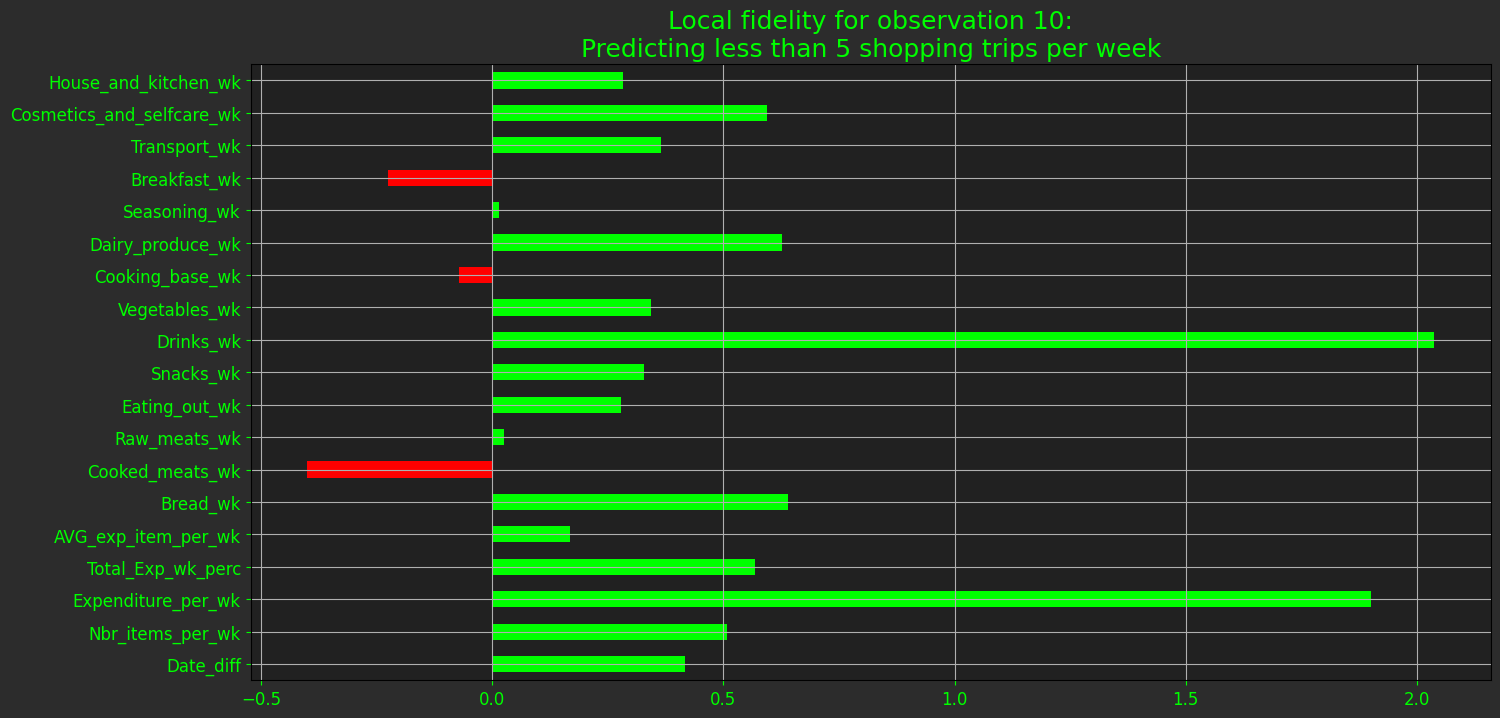

In [17]:
fig,ax = plt.subplots(figsize=(16,8))
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

# ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

pos_val = test_shap_10 > 0

test_shap_10.plot(ax=ax,
                kind='barh',
                color= pos_val.map({True:'lime', False: 'red'}),
                fontsize=12
               )
plt.grid()
plt.title('Local fidelity for observation 10:\nPredicting less than 5 shopping trips per week', fontsize=18)
plt.show()

<p>
The output shows that for observation 10 the positive feature contributions outwegh the negative feature contributions.<br>This will result in an overall positive effect on the prediction, pushing it higher which means higher probability of less than 5 shopping trips for the week.<br><br>
The main drivers of this prediction value are Drinks_wk, Expenditure_per_wk, Bread_wk, Dairy_produce.<br>
Note, there are also features that are pulling the prediction in the opposite direction: Cooked_meats_wk, Breakfast_wk and Cooking_base_wk.<br>

Below, the model is re-ran, this time for observation 10 only. Just for confirmation.
</p>

In [18]:
test10_data = X_test.loc[10:10,:]

# predicting Expenditure per week with the sample above
test_10_pred_proba = catb_final.predict_proba(test10_data)
test_10_pred = catb_final.predict(test10_data)

print(f"Less than 5 shopping trips: {test_10_pred[0]== 1} \
      \nWith a probability of: {'{:.3f}'.format(round(test_10_pred_proba[0,1],3))}")

Less than 5 shopping trips: True       
With a probability of: 1.000


The model output confirms that on the basis of observation 10 the prediction is less than 5 shopping trips in the week in question with a very high probability.

This will be compared with the output of observations 88 and 139 below.<br>

<b>For consistency, the same observations will be used for the regressor model.</b>

<h3 style="color: green;">Local fidelity for observation 88</h3>

In [19]:
test_shap_88 = pd.Series(X_test_shap_values[88,:], index=X_test.iloc[88,:].index)
test_shap_88

Date_diff                   -0.252467
Nbr_items_per_wk            -1.097181
Expenditure_per_wk          -1.641976
Total_Exp_wk_perc           -0.517670
AVG_exp_item_per_wk         -0.161219
Bread_wk                    -0.307931
Cooked_meats_wk              0.053570
Raw_meats_wk                -0.054802
Eating_out_wk               -0.608787
Snacks_wk                   -0.026741
Drinks_wk                   -1.891107
Vegetables_wk                0.106008
Cooking_base_wk             -0.003678
Dairy_produce_wk            -0.008847
Seasoning_wk                 0.091009
Breakfast_wk                -0.456912
Transport_wk                 0.032955
Cosmetics_and_selfcare_wk   -1.027476
House_and_kitchen_wk        -0.246913
dtype: float64

<h3 style="color: green;">Calculating the prediction shap value for observation 88</h3>

In [20]:
prediction_shap_88 =test_shap_88.sum() + explainer.expected_value
prediction_shap_88

-7.641734970857469

The output above is a large negative value indicating an overall negative effect. Thus it is expected that observation 88 is likely to result in more than 5 shopping trips per week.

<h3 style="color: green;">Plotting local fidelity for observation 88</h3>

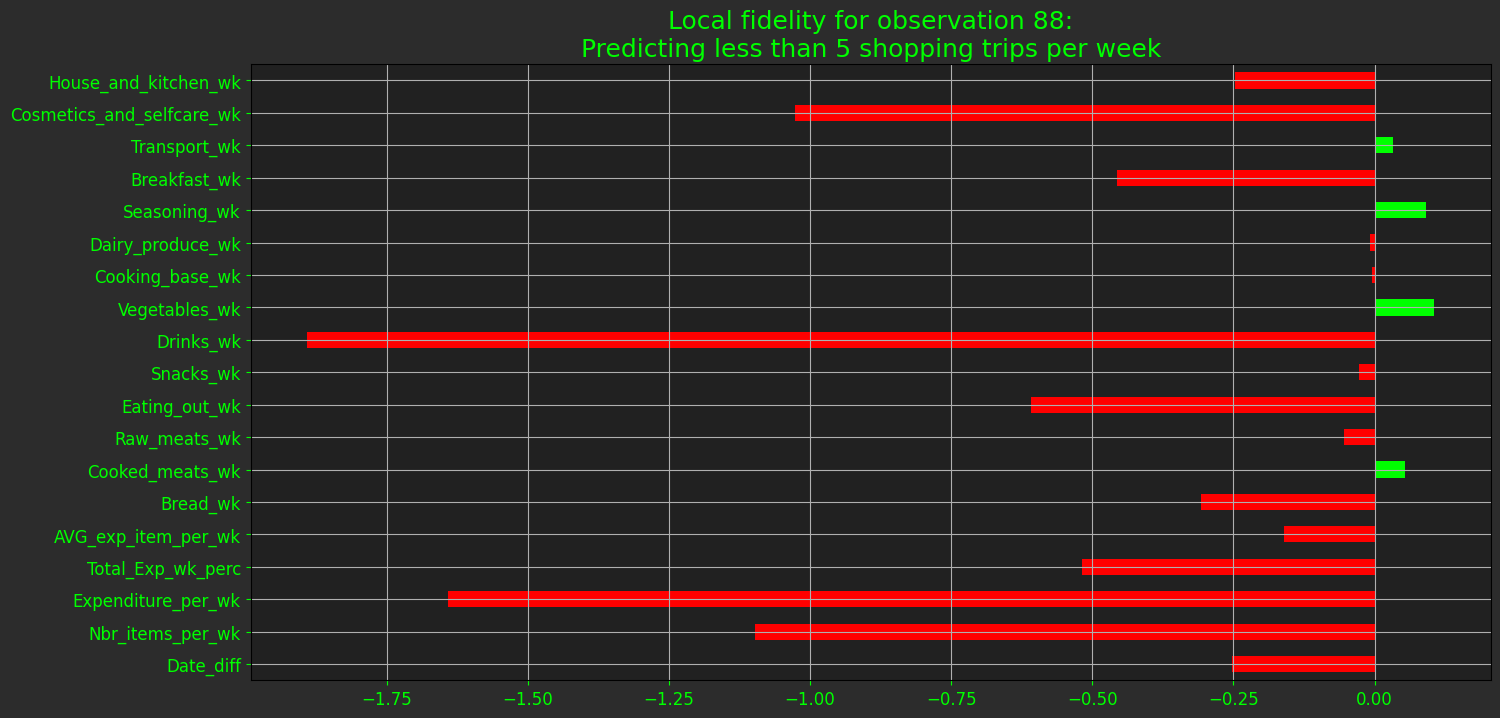

In [21]:
fig,ax = plt.subplots(figsize=(16,8))
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

pos_val = test_shap_88 > 0

test_shap_88.plot(ax=ax,
                kind='barh',
                color= pos_val.map({True:'lime', False: 'red'}),
                fontsize=12
               )
plt.grid()
plt.title('Local fidelity for observation 88:\nPredicting less than 5 shopping trips per week', fontsize=18)
plt.show()

<p>
The output shows that for observation 88 the negative feature contribution outweigh the positive feature<br> contribution. This will result  in an overall negative effect on the prediction, pushing it lower which means<br>
lower probability of less than 5 shopping trips for the week.<br><br>

Below, the model is re-ran, this time for observation 88 only. Just for confirmation.
</p>

In [22]:
test88_data = X_test.loc[88:88,:]

# predicting Expenditure per week with the sample above
test_88_pred_proba = catb_final.predict_proba(test88_data)
test_88_pred = catb_final.predict(test88_data)

print(f"Less than 5 shopping trips: {test_88_pred[0]== 1}:\
      \nWith a probability of: {'{:.3f}'.format(round(test_88_pred_proba[0,1],3))}")

Less than 5 shopping trips: False:      
With a probability of: 0.000


The model output confirms that on the basis of observation 88 the prediction is more than 5 shopping trips in the week in question with a very low probability, 0, of less than 5 shopping trips in the week in question.

<h3 style="color: green;">Local fidelity for observation 139</h3>

In [23]:
test_shap_139 = pd.Series(X_test_shap_values[139,:], index=X_test.iloc[139,:].index)
test_shap_139

Date_diff                   -0.398176
Nbr_items_per_wk            -0.683968
Expenditure_per_wk          -0.941977
Total_Exp_wk_perc           -0.174684
AVG_exp_item_per_wk         -0.240254
Bread_wk                    -0.203979
Cooked_meats_wk             -0.310292
Raw_meats_wk                -0.082804
Eating_out_wk                0.011251
Snacks_wk                   -0.240352
Drinks_wk                   -2.059898
Vegetables_wk                0.075994
Cooking_base_wk             -0.016057
Dairy_produce_wk             0.233698
Seasoning_wk                -0.014410
Breakfast_wk                -0.436660
Transport_wk                 0.070820
Cosmetics_and_selfcare_wk   -1.582076
House_and_kitchen_wk         0.039468
dtype: float64

<h3 style="color: green;">Calculating the prediction shap value for observation 139</h3>

In [24]:
prediction_shap_139 = test_shap_139.sum() + explainer.expected_value
prediction_shap_139

-6.575927244808275

The output above is a large negative value indicating an overall negative effect. Thus it is expected that observation 139 is likely to result in more than 5 shopping trips per week.

However, the associated probability is expected to be slightly higher than the probability of observation 88.

<h3 style="color: green;">Plotting local fidelity for observation 139</h3>

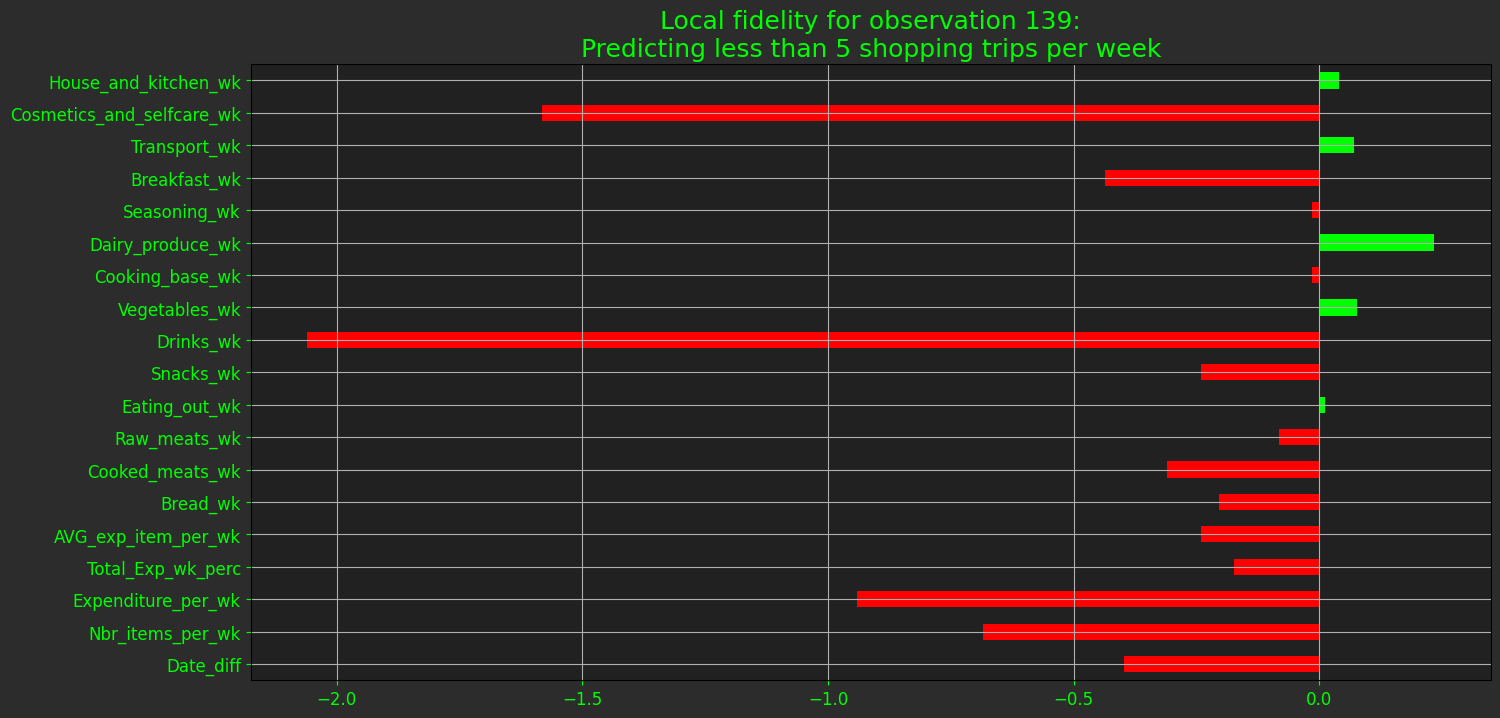

In [25]:
fig,ax = plt.subplots(figsize=(16,8))
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

pos_val = test_shap_139 > 0

test_shap_139.plot(ax=ax,
                kind='barh',
                color= pos_val.map({True:'lime', False: 'red'}),
                fontsize=12
               )
plt.grid()
plt.title('Local fidelity for observation 139:\nPredicting less than 5 shopping trips per week', fontsize=18)
plt.show()

The output shows that for observation 139 the negative feature contribution outweigh the positive feature
contribution. This will result in an overall negative effect on the prediction, pushing it lower which means
lower probability of less than 5 shopping trips for the week.

Below, the model is re-ran, this time for observation 139 only. Just for confirmation.

In [26]:
test139_data = X_test.loc[139:139,:]

# predicting Expenditure per week with the sample above
test_139_pred_proba = catb_final.predict_proba(test139_data)
test_139_pred = catb_final.predict(test139_data)

print(f"Less than 5 shopping trips: {test_139_pred[0]== 1}:\
      \nWith a probability of: {'{:.3f}'.format(round(test_139_pred_proba[0,1],3))}")

Less than 5 shopping trips: False:      
With a probability of: 0.001


The model output confirms that on the basis of observation 139 the prediction is more than 5 shopping trips in the week in question with a very low probability of less than 5 shopping trips in the week in question.

<h1 style="color: green;">Summary</h1>
<p>
Above, the model output have been explained using global fidelity and local fidelity.<br>
How the features account for the shifts that result in the prediction output have all been visualized.<br><br>
Machine learning models are complexed. Explainable AI tools such as SHAP values are effective in visualizing<br>
the contribution of each feature in generating the prediction. If prediction contributing factors can be understood<br>it makes it easier for non technical individuals to trust the model outputs.<br><br>
</p>